In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df=pd.read_csv('dataset.csv')
df=df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2882391, 4)


,t,v,q,T
1453232,735954.8158,4.1896,0.0000,40.1107
1453233,735954.8159,4.1738,-0.1952,40.1232
1453234,735954.8159,4.1722,-0.4006,40.1357
1453235,735954.8159,4.1709,-0.6060,40.1357
1453236,735954.8159,4.1695,-0.8114,40.0234


In [3]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.t.min())
print('The time series ends on: ', df.t.max())

Number of rows and columns after removing missing values: (2882391, 4)
The time series starts from:  735954.8158387741
The time series ends on:  736593.547944232


### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: -1.1512196998374589
Skewness of normal distribution: 0.003563327726374702


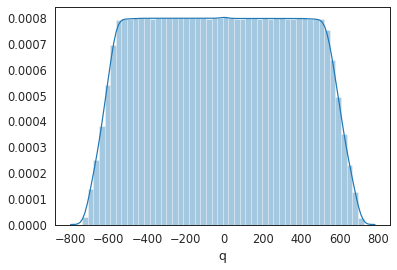

In [4]:
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

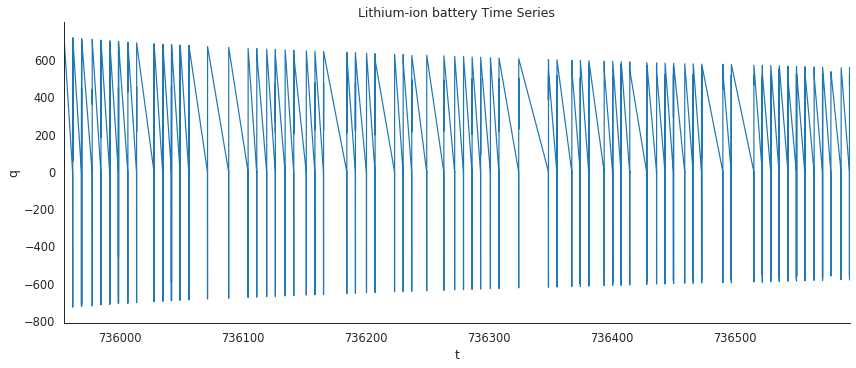

In [5]:
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();

## LSTM

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [6]:
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [9]:
X_train.shape

(2305881, 30)

In [10]:
Y_train.shape

(2305881,)

In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [12]:
X_train.shape

(2305881, 1, 30)

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2305881 samples, validate on 576448 samples
Epoch 1/100
2305881/2305881 [==============================] - 82s 36us/step - loss: 0.0029 - val_loss: 0.0095
Epoch 2/100
2305881/2305881 [==============================] - 82s 35us/step - loss: 0.0018 - val_loss: 0.0048
Epoch 3/100
2305881/2305881 [==============================] - 71s 31us/step - loss: 0.0015 - val_loss: 0.0041
Epoch 4/100
2305881/2305881 [==============================] - 71s 31us/step - loss: 0.0013 - val_loss: 0.0030
Epoch 5/100
2305881/2305881 [==============================] - 76s 33us/step - loss: 0.0011 - val_loss: 0.0034
Epoch 6/100
2305881/2305881 [==============================] - 79s 34us/step - loss: 9.3901e-04 - val_loss: 0.0040
Epoch 7/100
2305881/2305881 [==============================] - 76s 33us/step - loss: 8.5397e-04 - val_loss: 0.0034
Epoch 8/100
2305881/2305881 [=============

In [14]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 36.88196179387104
Train Root Mean Squared Error: 60.841874349547645
Test Mean Absolute Error: 23.70508735735503
Test Root Mean Squared Error: 38.86651611017475


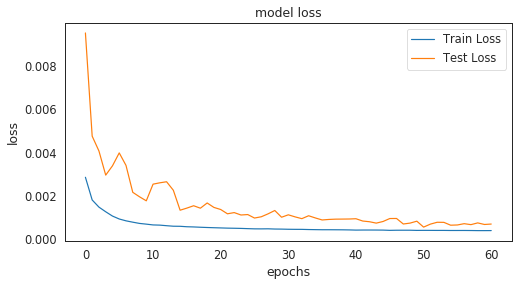

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

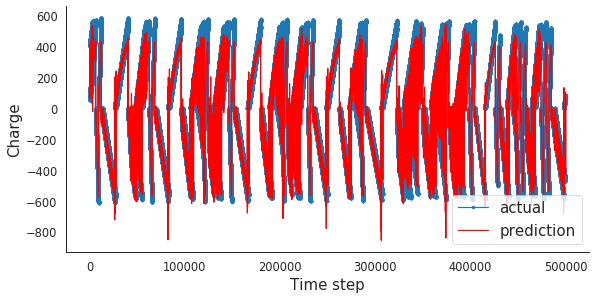

In [23]:
aa=[x for x in range(500000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:500000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();